# XGBoost Classifier -  Telco Customer Churn IBM Dataset

Based in the work of Josh Starmer.

<img src="images/churn.jpg"/>

**Customer churn** is a financial term that refers to the loss of a client or customer—that is, when a customer ceases to interact with a company or business. Similarly, the churn rate is the rate at which customers or clients are leaving a company within a specific period of time. A churn rate higher than a certain threshold can have both tangible and intangible effects on a company's business success. Ideally, companies like to retain as many customers as they can.

### Libraries

In [1]:
import numpy as np               
import pandas as pd               
import xgboost as xgb   
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

### Get the Data

Data source: https://www.kaggle.com/yeanzc/telco-customer-churn-ibm-dataset

In [2]:
# load and preview data

df = pd.read_excel('data/Telco_customer_churn.xlsx')

df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [3]:
# view summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [4]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [5]:
# Drop some columns
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], axis=1, inplace=True)

In [6]:
df['Count'].unique()

array([1], dtype=int64)

In [7]:
df['Country'].unique()

array(['United States'], dtype=object)

In [8]:
df['State'].unique()

array(['California'], dtype=object)

In [9]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

In [10]:
# Drop more columns
df.drop(['CustomerID', 'Count', 'Country', 'State', 'Lat Long'], axis=1, inplace=True)

df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


XGBoost manage well blanc space in variables, but for plot trees, it is necessary replace ' ' for _.

In [11]:
df['City'].replace(' ', '_', regex=True, inplace=True)

df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [12]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

In [13]:
# Convert column names too
df.columns = df.columns.str.replace(' ','_')
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

In [14]:
# Columns type
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [15]:
df['Phone_Service'].unique()

array(['Yes', 'No'], dtype=object)

In [16]:
df['Total_Charges'].unique()

array([108.15, 151.65, 820.5, ..., 7362.9, 346.45, 6844.5], dtype=object)

Using 
    *df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])*, we receive a error saying that there is blanc spaces in this column, therefore, it is not possible to convert.

In [17]:
# See how many occurrences
len(df.loc[df['Total_Charges']==' '])

11

In [18]:
# Let's look them
df.loc[df['Total_Charges']==' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


In [19]:
# Set the 'Total_Charges' to 0 in these 11 cases, ' ' to zero.

df.loc[(df['Total_Charges']==' '), 'Total_Charges'] = 0

In [20]:
# Check
len(df.loc[df['Total_Charges']==' '])

0

In [21]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

In [22]:
# Now, let's do the same for All DataFrame.

df.replace(' ', '_', regex=True, inplace=True)

df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


### Split the Data

In [23]:
X = df.drop('Churn_Value', axis=1).copy()   # alternatively: X = df_no_missing.iloc[:,:-1]

y = df['Churn_Value'].copy()

In [24]:
df['Payment_Method'].unique()

array(['Mailed_check', 'Electronic_check', 'Bank_transfer_(automatic)',
       'Credit_card_(automatic)'], dtype=object)

In [25]:
# One-Hot Encoding View
pd.get_dummies(X, columns=['Payment_Method']).head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Monthly_Charges,Total_Charges,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,Month-to-month,Yes,53.85,108.15,0,0,0,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,Month-to-month,Yes,70.70,151.65,0,0,1,0
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,Yes,Month-to-month,Yes,99.65,820.50,0,0,1,0
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Month-to-month,Yes,104.80,3046.05,0,0,1,0
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,Month-to-month,Yes,103.70,5036.30,1,0,0,0


In [26]:
X.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges'],
      dtype='object')

In [27]:
# Let's do it for all qualitative columns 

X_encoded = pd.get_dummies(X, columns=['City',
                                       'Gender',
                                       'Senior_Citizen', 
                                       'Partner', 
                                       'Dependents', 
                                       'Phone_Service',
                                       'Multiple_Lines', 
                                       'Internet_Service', 
                                       'Online_Security',
                                       'Online_Backup', 
                                       'Device_Protection', 
                                       'Tech_Support', 
                                       'Streaming_TV',
                                       'Streaming_Movies', 
                                       'Contract', 
                                       'Paperless_Billing', 
                                       'Payment_Method'])
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0


In [28]:
# Verify 'y'
y.unique()

array([1, 0], dtype=int64)

### Build the XGBoost Model

In [29]:
# Lets see how imbalance is this dataset looking for y=1:
sum(y) / len(y)

0.2653698707936959

In [30]:
# Split the trains and tests
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [31]:
# Let's see if stratify worked as expected, creating groups with the same proportion of 1's and 0's.

print(sum(y_train) / len(y_train))
print(sum(y_test) / len(y_test))

0.2654297614539947
0.26519023282226006


In [32]:
# Create the XGBoost Model

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, use_label_encoder=False, seed=42)# Create a shell

clf_xgb.fit(X_train,     # Training data
            y_train,     # Training data
            verbose=True,                 # Verbosity of printing messages
            early_stopping_rounds=10,     # After 10 trees without improvement, stop (avoid overfitting)
            eval_metric='aucpr',          # Area under the PR curve
            eval_set=[(X_test,y_test)])   # Train with the train dataset, but evaluete the how many trees with the test dataset

[0]	validation_0-aucpr:0.64036
[1]	validation_0-aucpr:0.64404
[2]	validation_0-aucpr:0.65124
[3]	validation_0-aucpr:0.65051
[4]	validation_0-aucpr:0.65321
[5]	validation_0-aucpr:0.64854
[6]	validation_0-aucpr:0.65459
[7]	validation_0-aucpr:0.65895
[8]	validation_0-aucpr:0.65746
[9]	validation_0-aucpr:0.65850
[10]	validation_0-aucpr:0.66217
[11]	validation_0-aucpr:0.66527
[12]	validation_0-aucpr:0.66322
[13]	validation_0-aucpr:0.66310
[14]	validation_0-aucpr:0.66000
[15]	validation_0-aucpr:0.66027
[16]	validation_0-aucpr:0.65781
[17]	validation_0-aucpr:0.65593
[18]	validation_0-aucpr:0.65738
[19]	validation_0-aucpr:0.65829
[20]	validation_0-aucpr:0.65683
[21]	validation_0-aucpr:0.65707


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

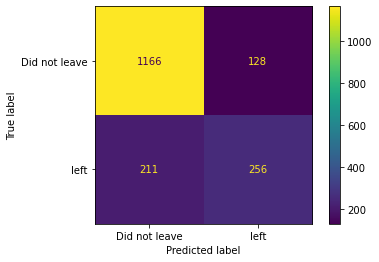

In [33]:
# Plot Confusion Matrix

plot_confusion_matrix(clf_xgb,            # estimator
                      X_test,             # X
                      y_test,             # y-true
                      values_format='d',
                      display_labels=['Did not leave', 'left'])

Beacuse the data is imbalanced, xgboost did'n't make a great job in the first approach. Wew can improve using a xgboost parameter called 'scale_pos_weight' that helps with imbalanced data.

In [34]:
# New XGBoost Model

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            gamma=0.25,             # Minimum loss reduction required to make a further partition on a leaf
                            learn_rate=0.1,         # Eta, step size shrinkage used in update to prevents overfitting
                            max_depth=4,            # Maximum depth of a tree
                            reg_lambda=10,          # Lambda, L2 regularization term on weights.
                            scale_pos_weight=3,     # Control the balance of positive and negative weights
                            subsample=0.9,          # Randomly sample part of the training data prior to growing trees
                            colsample_bytree=0.5,   # Subsampling of columns
                            missing=None,
                            use_label_encoder=False,
                            seed=42)                              

clf_xgb.fit(X_train,     
            y_train,     
            verbose=True,                 # Verbosity of printing messages
            early_stopping_rounds=10,     # After 10 trees without improvement, stop (avoid overfitting)
            eval_metric='aucpr',          # Area under the PR curve
            eval_set=[(X_test,y_test)])   # Train with the train dataset, but evaluete the how many trees with the test dataset

[21:27:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.56622
[1]	validation_0-aucpr:0.59633
[2]	validation_0-aucpr:0.62538
[3]	validation_0-aucpr:0.63059
[4]	validation_0-aucpr:0.63626
[5]	validation_0-aucpr:0.64668
[6]	validation_0-aucpr:0.64032
[7]	validation_0-aucpr:0.64428
[8]	validation_0-aucpr:0.64448
[9]	validation_0-aucpr:0.65640
[10]	validation_0-aucpr:0.65543
[11]	validation_0-aucpr:0.66453
[12]	validation_0-aucpr:0.66361
[13]	validation_0-aucpr:0.66424
[14]	validation_0-aucpr:0.66289
[15]	validation_0-aucpr:0.66315
[16]	validation_0-aucpr:0.66231
[17]	validation_0-aucpr:0.66141
[18]	validation_0-aucpr:0.66036
[19]	validatio

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.25, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.1, learning_rate=0.300000012, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=None,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=10,
              scale_pos_weight=3, seed=42, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

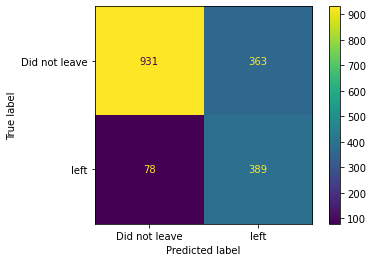

In [35]:
# Plot Confusion Matrix

plot_confusion_matrix(clf_xgb,            # estimator
                      X_test,             # X
                      y_test,             # y-true
                      values_format='d',
                      display_labels=['Did not leave', 'left'])

A better job classifying people that left the company, our goal here. The last thing is make the tree.

### Plot the Tree

[21:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:28:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight  {'Tech_Support_No': 1, 'Contract_Two_year': 1, 'Internet_Service_Fiber_optic': 1, 'Tenure_Months': 5, 'Monthly_Charges': 2, 'Latitude': 1, 'Internet_Service_DSL': 2, 'Contract_One_year': 1, 'Senior_Citizen_No': 1}
gain  {'Tech_Support_No': 1133.81055, 'Contract_Two_year': 252.511536, 'Internet

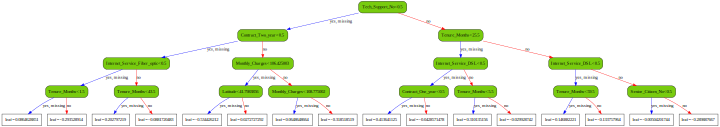

In [36]:
# Create a XGBoost Model with 'n_estimators=1', to make the tree

clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            gamma=0.25,             
                            learn_rate=0.1,         
                            max_depth=4,            
                            reg_lambda=10,          
                            scale_pos_weight=3,     
                            subsample=0.9,          
                            colsample_bytree=0.5,    
                            missing=None,
                            use_label_encoder=False,
                            n_estimators=1,          # build one tree, so we can get gain, cover, etc.
                            seed=42)                              

clf_xgb.fit(X_train, y_train)

bst = clf_xgb.get_booster()

for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    
    print('%s ' % importance_type, bst.get_score(importance_type=importance_type))
    
node_params = {'shape':'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}

leaf_params = {'shape':'box',
               'style': 'fille',
               'fillcolor': '#e48038'}

xgb.to_graphviz(clf_xgb, num_tree=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

In [37]:
# To save the figure:

graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                             condition_node_params=node_params,
                             leaf_node_params=leaf_params)
graph_data.view(filename='images/xgboost_tree_customer_churn') ## save as PDF

'images\\xgboost_tree_customer_churn.pdf'

In [38]:
# Alternative Plot:
#
#import matplotlib.pyplot as plt
#
#xgb.plot_tree(clf_xgb,num_trees=0)
#plt.rcParams['figure.figsize'] = [10, 10]
#plt.show()